<a href="https://colab.research.google.com/github/imenebak/VisDrone_CC/blob/master/Visdrone2019_dotAnnotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip "/content/drive/My Drive/VisDrone2019-VID-train.zip" -d "/content/"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/VisDrone2019-VID-train/sequences/uav0000308_00000_v/0000146.jpg  
  inflating: /content/VisDrone2019-VID-train/sequences/uav0000308_00000_v/0000147.jpg  
  inflating: /content/VisDrone2019-VID-train/sequences/uav0000308_00000_v/0000148.jpg  
  inflating: /content/VisDrone2019-VID-train/sequences/uav0000308_00000_v/0000149.jpg  
  inflating: /content/VisDrone2019-VID-train/sequences/uav0000308_00000_v/0000150.jpg  
  inflating: /content/VisDrone2019-VID-train/sequences/uav0000308_00000_v/0000151.jpg  
  inflating: /content/VisDrone2019-VID-train/sequences/uav0000308_00000_v/0000152.jpg  
  inflating: /content/VisDrone2019-VID-train/sequences/uav0000308_00000_v/0000153.jpg  
  inflating: /content/VisDrone2019-VID-train/sequences/uav0000308_00000_v/0000154.jpg  
  inflating: /content/VisDrone2019-VID-train/sequences/uav0000308_00000_v/0000155.jpg  
  inflating: /content/VisDrone2019-VID-tra

In [0]:
import torch
import pandas as pd
import numpy as np
import glob, os
from scipy.spatial import KDTree
from scipy import ndimage
import imageio
import scipy
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import logging
from multiprocessing import Pool
from scipy.ndimage.filters import gaussian_filter

In [0]:
import math
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

In [0]:
logger = logging.getLogger()
hdlr = logging.FileHandler(os.path.join('data_generator.log'))
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr) 
logger.setLevel(logging.INFO)

In [0]:
def gaussian_filter_density(gt):
    '''
    convert one-hot map to gaussian filtered map
    @param gt: np.array with shape [h, w], one-hot encoded map
    @output density: a gaussian filtered hot map
    '''
#     print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.nonzero(gt)
    pts = np.vstack([pts[1], pts[0]]).T

    leafsize = 2048
    # build kdtree
    tree = KDTree(pts, leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

#     print('generate density...')
    for i, pt in enumerate(pts):
#         print(i, pt)
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.3/3
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
#     print('done.')
    return density

In [0]:
v_list = sorted(glob.glob('train/sequences/*'))
a_list = sorted(glob.glob('train/annotations/*'))
col_name = ["img","id", "x", "y", "w", "h", "score", "label", "unknown1", "unknown2"]

In [0]:
len(v_list)

6

In [0]:
# Cat 0 : ignored regions
# Cat 1 : pedestrian
# Cat 2 : people
# Cat 3 : bicycle 
# Cat 4 : car
# Cat 5 : van
# Cat 6 : truck
# Cat 7 : tricycle
# Cat 8 : awning-tricycle
# Cat 9 : bus
# Cat 10 : motor
# Cat 11 : others

In [0]:
categories = ['ignored regions', 'pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']

In [0]:
label = ['ignored regions', 'pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']

In [0]:
# frame_index = line_data[0]
# target_id = line_data[1]
# bbox_left= line_data[2]
# bbox_top = line_data[3]
#img_width = int(line_data[4])
#img_height = int(line_data[5])
#object_category = int(line_data[7])
# truncation = line_data[8]
# occlusion = line_data[9]

In [0]:
num_category = 12
data = []
for i in range(0,num_category):
	data.append([])

In [0]:
data

[[], [], [], [], [], [], [], [], [], [], [], []]

In [0]:
files = [f for f in listdir('train/annotations/') if isfile(join('train/annotations/', f))]

In [0]:
files

['uav0000071_03240_v.txt',
 'uav0000013_00000_v.txt',
 'uav0000020_00406_v.txt',
 'uav0000084_00000_v.txt',
 'uav0000072_06432_v.txt',
 'uav0000138_00000_v.txt']

In [0]:
for file in files:
  f = open("train/annotations/" + file, 'r')
  while True:
    line = f.readline()
    if not line:
      break
      line = line.rstrip()
    line_data = line.split(',')
    img_width = int(line_data[4])
    img_height = int(line_data[5])
    object_category = int(line_data[7])
	    # truncation = line_data[8]
	    # occlusion = line_data[9]
    data[object_category].append(math.sqrt(img_height * img_width))
  f.close()

# of category 1 : 47287 (pedestrian)
# of category 2 : 14899 (people)


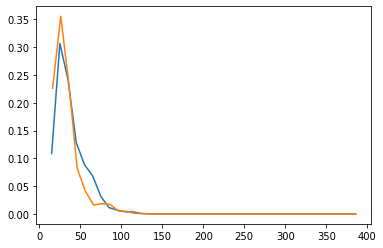

In [0]:
for i in range(1,3):
# for i in range(0,2):
	print('# of category ' + str(i) + ' : ' + str(len(data[i])) +" ("+label[i]+")")
	bins = np.arange(min(data[i]), 400, 10)
	hist,bins = np.histogram(data[i], bins)
	hist_sum = sum(hist)
	hist = hist/float(hist_sum)
	plt.plot(bins[0:(len(hist))],hist)
	categories[i] = categories[i] + ': ' + "{:,}".format(len(data[i]))
	# print(hist)
	# print(bins)

In [0]:
import os

In [0]:
!rm -r train

rm: cannot remove 'train': No such file or directory


In [0]:
root = "train/sequences"

In [0]:
for path, dirs, files in os.walk(root):
  path_d = dirs
  break

In [0]:
path_d

['uav0000013_00000_v',
 'uav0000281_00460_v',
 'uav0000266_03598_v',
 'uav0000273_00001_v',
 'uav0000239_03720_v',
 'uav0000243_00001_v',
 'uav0000218_00001_v',
 'uav0000288_00001_v',
 'uav0000013_01392_v',
 'uav0000278_00001_v',
 'uav0000248_00001_v',
 'uav0000140_01590_v',
 'uav0000270_00001_v',
 'uav0000326_01035_v',
 'uav0000361_02323_v',
 'uav0000020_00406_v',
 'uav0000126_00001_v',
 'uav0000145_00000_v',
 'uav0000084_00000_v',
 'uav0000366_00001_v',
 'uav0000295_02300_v',
 'uav0000072_04488_v',
 'uav0000352_05980_v',
 'uav0000315_00000_v',
 'uav0000289_00001_v',
 'uav0000307_00000_v',
 'uav0000079_00480_v',
 'uav0000072_06432_v',
 'uav0000239_12336_v',
 'uav0000222_03150_v',
 'uav0000072_05448_v',
 'uav0000300_00000_v',
 'uav0000143_02250_v',
 'uav0000244_01440_v',
 'uav0000150_02310_v',
 'uav0000363_00001_v',
 'uav0000099_02109_v',
 'uav0000289_06922_v',
 'uav0000308_00000_v',
 'uav0000309_00000_v',
 'uav0000263_03289_v',
 'uav0000342_04692_v',
 'uav0000279_00001_v',
 'uav000007

In [0]:
import shutil, cv2

In [0]:
from google.colab.patches import cv2_imshow

In [0]:
def anno(annotation):
  pos = 0
  for nbr in annotation:
          if nbr != '0':
            #print(nbr)
            annotation = annotation[pos:]
            break
          pos+=1
  return annotation

In [0]:
def new_ann(new_a, line):
  new_a.append(line[0])
  new_a.append(int(int(line[2])+ (int(line[4])/2)))
  new_a.append(int(int(line[3])+ (int(line[5])/2)))
  return new_a

In [0]:
try:
    os.mkdir("/content/train/annotation_dots")
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Successfully created the directory train/sequences 


[123, 342, 622]
[123, 347, 606]
[123, 401, 431]
[123, 393, 419]
[123, 422, 424]
[123, 432, 357]
[123, 518, 399]
[123, 617, 318]
[123, 503, 379]
[123, 510, 368]
[123, 514, 357]
[123, 632, 312]
[123, 674, 383]
[123, 628, 385]
[123, 578, 264]
[123, 718, 404]
[123, 721, 406]
[123, 774, 287]
[123, 571, 171]
[123, 547, 303]
[123, 536, 310]
[123, 538, 308]
[123, 456, 371]


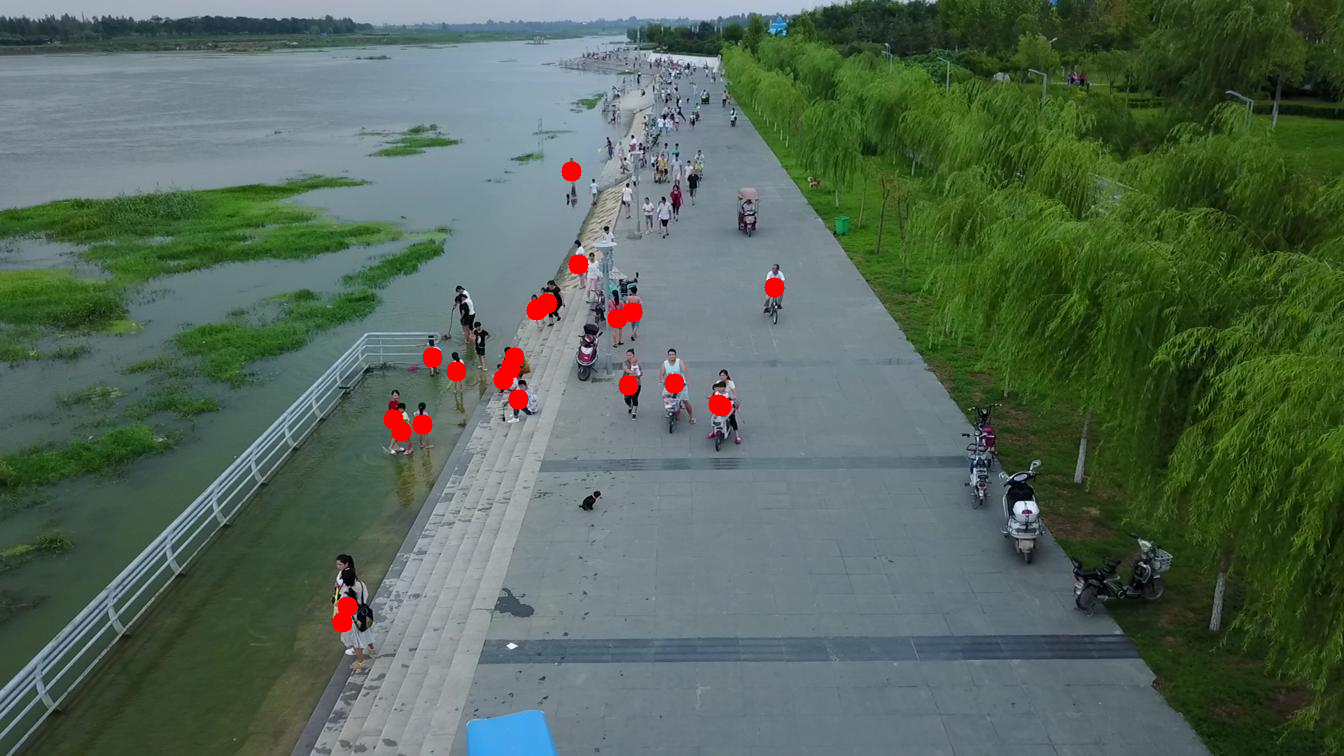

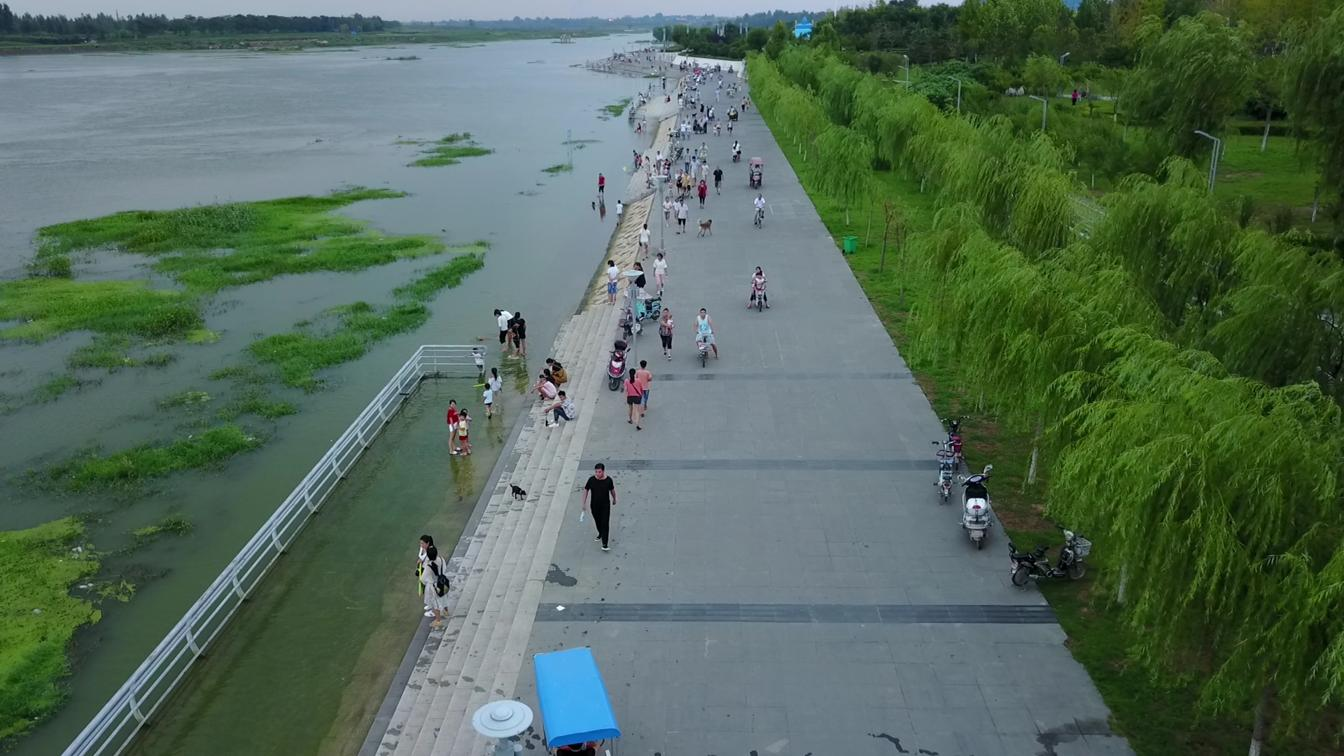

In [0]:
for i in path_d[3:]:
  if i == '.ipynb_checkpoints': pass
  else:
    file_annota = open(root.replace('sequences','annotations')+"/"+i+ ".txt", "r")
    mon_fichier = open("/content/test/annotations_dots/"+i+ ".txt", "w")
    dossier=root+"/"+i
    for path, dirs, files in os.walk(dossier):
      for fi in files:
        
        person = 0
        img = cv2.imread(dossier+"/"+fi)
        annotation = fi.replace('.jpg','')
        annotation = anno(annotation)
        lines = file_annota.readlines()
        for ligne in lines:
          line = ligne.strip()
          line = line.split(",")
          line = list(map(int, line))
          #print(line)
          if line[0] == int(annotation):
            if (int(line[7]) == 1) | (int(line[7]) == 2):
              new_a = []
              person = 1
              new_a = new_ann(new_a, line)
              print(new_a)
              #mon_fichier.write(str(new_a[0])+','+str(new_a[1])+','+str(new_a[2]))
              img = cv2.circle(img,(new_a[1],new_a[2]), 10, (0,0,255), -1)
            #file_annota = open(root.replace('sequences','annotations')+"/"+i+ ".txt", "w")
        break
      file_annota.close()
      break
       
    #break
cv2_imshow(img)

In [0]:
useless=[]

In [0]:
for i in path_d:
  if i == '.ipynb_checkpoints': pass
  else:
    file_annota = open(root.replace('sequences','annotations')+"/"+i+ ".txt", "r")
    lines = file_annota.readlines()
    mon_fichier = open("/content/train/annotation_dots/"+i+ ".txt", "w")
    dossier=root+"/"+i
    count =0
    for path, dirs, files in os.walk(dossier):
      for fi in files:
        person = 0
        #print(dossier+"/"+fi)
        annotation = fi.replace('.jpg','')
        annotation = anno(annotation)
        for ligne in lines:
          line = ligne.strip()
          line = line.split(",")
          line = list(map(int, line))
          #print(line)
          #print(line)
          if line[0] == int(annotation):
            if (int(line[7]) == 1) | (int(line[7]) == 2):
              count+=1
              new_a = []
              person = 1
              new_a = new_ann(new_a, line)
              mon_fichier.write(str(new_a[0])+','+str(new_a[1])+','+str(new_a[2])+'\n')
            #file_annota = open(root.replace('sequences','annotations')+"/"+i+ ".txt", "w")
      if person == 0:
          useless.append(dossier+"/"+fi)
    print(i,"persons : ", count, "images: ",len(files), "moyenne",count//len(files))
    file_annota.close()

uav0000013_00000_v persons :  5776 images:  269 moyenne 21
uav0000281_00460_v persons :  5498 images:  508 moyenne 10
uav0000266_03598_v persons :  1644 images:  548 moyenne 3
uav0000273_00001_v persons :  2066 images:  872 moyenne 2
uav0000239_03720_v persons :  2944 images:  680 moyenne 4
uav0000243_00001_v persons :  2058 images:  768 moyenne 2
uav0000218_00001_v persons :  4 images:  225 moyenne 0
uav0000288_00001_v persons :  26034 images:  1424 moyenne 18
uav0000013_01392_v persons :  1899 images:  118 moyenne 16
uav0000278_00001_v persons :  10906 images:  962 moyenne 11
uav0000248_00001_v persons :  1945 images:  677 moyenne 2
uav0000140_01590_v persons :  1571 images:  256 moyenne 6
uav0000270_00001_v persons :  10164 images:  680 moyenne 14
uav0000326_01035_v persons :  1608 images:  369 moyenne 4
uav0000361_02323_v persons :  3620 images:  219 moyenne 16
uav0000020_00406_v persons :  7425 images:  501 moyenne 14
uav0000126_00001_v persons :  6302 images:  412 moyenne 15
uav0

In [0]:
seq = ["uav0000138_00000_v", "uav0000072_06432_v", "uav0000072_04488_v", "uav0000084_00000_v"]

In [0]:
root = "train/"
root2 = "new/"
for i in seq:
  shutil.copytree(root+"sequences/"+i, root2+"sequences/"+i)
  shutil.copyfile(root+"annotation_dots/"+i+".txt", root2+"annotations/"+i+".txt")


In [0]:
!rm -r /content/new/sequences/uav0000138_00000_v

In [0]:
!rm -r train

In [0]:
!zip -r visdrone2019_annotation_dots.zip visdrone2019_annotation_dots

updating: visdrone2019_annotation_dots/ (stored 0%)
  adding: visdrone2019_annotation_dots/.ipynb_checkpoints/ (stored 0%)
  adding: visdrone2019_annotation_dots/annotations/ (stored 0%)
  adding: visdrone2019_annotation_dots/annotations/uav0000138_00000_v.txt (deflated 63%)
  adding: visdrone2019_annotation_dots/annotations/uav0000072_06432_v.txt (deflated 61%)
  adding: visdrone2019_annotation_dots/annotations/uav0000084_00000_v.txt (deflated 64%)
  adding: visdrone2019_annotation_dots/annotations/uav0000072_04488_v.txt (deflated 61%)
  adding: visdrone2019_annotation_dots/sequences/ (stored 0%)
  adding: visdrone2019_annotation_dots/sequences/uav0000084_00000_v/ (stored 0%)
  adding: visdrone2019_annotation_dots/sequences/uav0000084_00000_v/0000286.jpg (deflated 0%)
  adding: visdrone2019_annotation_dots/sequences/uav0000084_00000_v/0000027.jpg (deflated 0%)
  adding: visdrone2019_annotation_dots/sequences/uav0000084_00000_v/0000426.jpg (deflated 0%)
  adding: visdrone2019_annotatio

In [0]:
!cp visdrone2019_annotation_dots.zip "/content/drive/My Drive/VisdroneCrowdCounting"